In [7]:
import pandas as pd

raw_data: pd.DataFrame = pd.read_csv('data/fake_job_postings.csv')
raw_data

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [8]:
# Create new dataframe with concatenated text columns and fraudulent label
data = pd.DataFrame({
  'job_description': raw_data[['company_profile', 'description', 'requirements', 'benefits']].fillna('').agg(' '.join, axis=1),
  'fraudulent': raw_data['fraudulent']
})
data

,job_description,fraudulent
0,"We're Food52, and we've created a groundbreaki...",0
1,"90 Seconds, the worlds Cloud Video Production ...",0
2,Valor Services provides Workforce Solutions th...,0
3,Our passion for improving quality of life thro...,0
4,SpotSource Solutions LLC is a Global Human Cap...,0
...,...,...
17875,Vend is looking for some awesome new talent to...,0
17876,WebLinc is the e-commerce platform and service...,0
17877,We Provide Full Time Permanent Positions for m...,0
17878,Nemsia Studios is looking for an experienced ...,0


## Data Exploration

Plot a histogram of the lengths of the `job_description` for fraudulent and non-fraudulent job postings

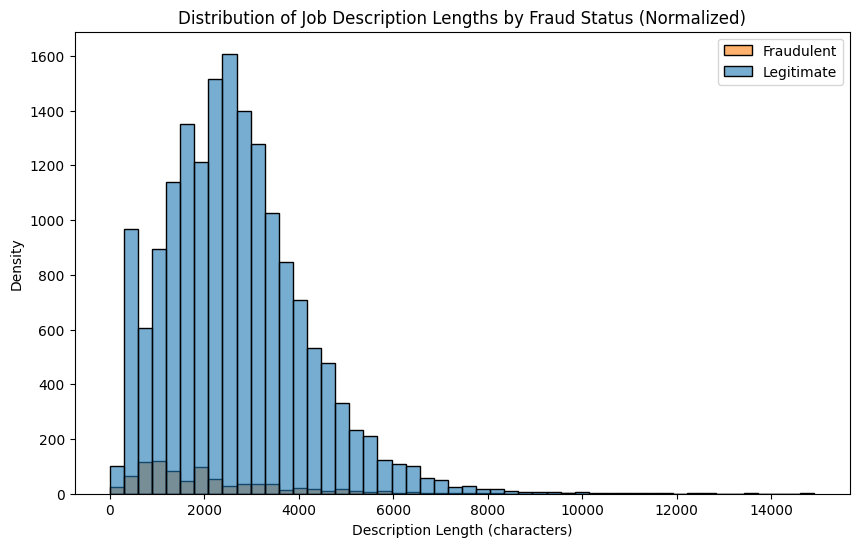

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate lengths of job descriptions
data['description_length'] = data['job_description'].str.len()

plt.figure(figsize=(10,6))
sns.histplot(data=data, x='description_length', hue='fraudulent', bins=50, 
       multiple="layer", alpha=0.6, stat='count')
plt.title('Distribution of Job Description Lengths by Fraud Status (Normalized)')
plt.xlabel('Description Length (characters)')
plt.ylabel('Density')
plt.legend(labels=['Fraudulent', 'Legitimate'])

In [10]:
# Average description length by fraudulent status
data.groupby('fraudulent')['description_length'].mean()


fraudulent
0    2671.165981
1    2046.972286
Name: description_length, dtype: float64

In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['job_description'], data['fraudulent'], test_size=0.2, random_state=42
)

# Oversampling the minority class in the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_frame(), y_train)
X_train = X_train_resampled['job_description']
y_train = y_train_resampled
# Checking new class distribution
print(y_train_resampled.value_counts())


fraudulent
0    13619
1    13619
Name: count, dtype: int64


Number of fraudulent and non-fraudulent job postings in the testing set

In [13]:
y_test.value_counts()

fraudulent
0    3395
1     181
Name: count, dtype: int64

Use `TfidfVectorizer` to convert text data into vectors

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=60000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(X_train_vec.shape)

(27238, 60000)


In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9804250559284117

In [35]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[3354,   41],
       [  29,  152]])

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.79      0.84      0.81       181

    accuracy                           0.98      3576
   macro avg       0.89      0.91      0.90      3576
weighted avg       0.98      0.98      0.98      3576

